In [1]:
# import test.gene_classifier_2 as classifier
import pandas as pd
import scanpy as sc
import scvelo as scv
import anndata as ad
import numpy as np
import test.utils as utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = ad.read('data/mouse_dynam_682_cells_7119_genes.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 682 × 7119
    obs: 'plate', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'leiden', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'leiden', 'neighbors', 'pca', 'plate_colors', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spanning', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

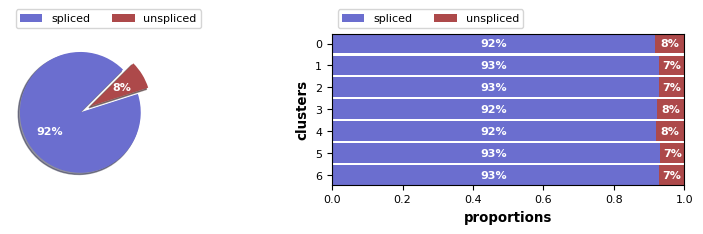

In [4]:
scv.pl.proportions(adata)

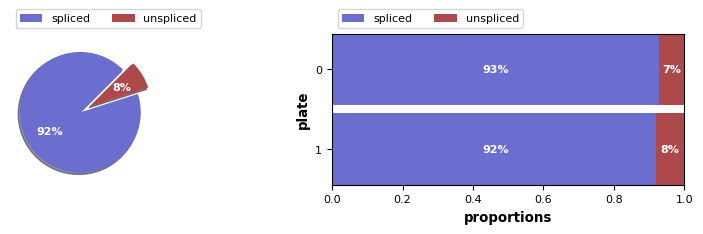

In [5]:
scv.pl.proportions(adata, groupby='plate')

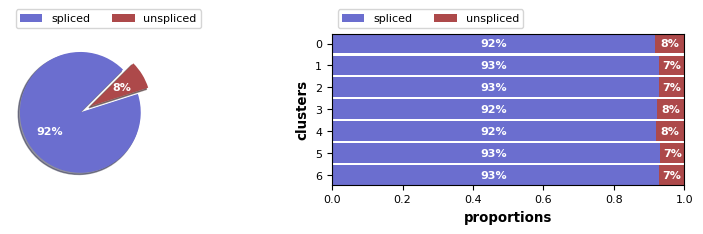

In [6]:
scv.pl.proportions(adata, groupby='clusters')

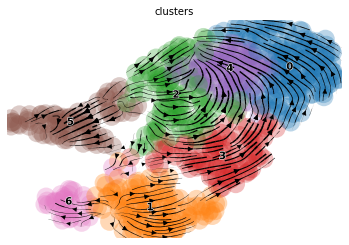

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

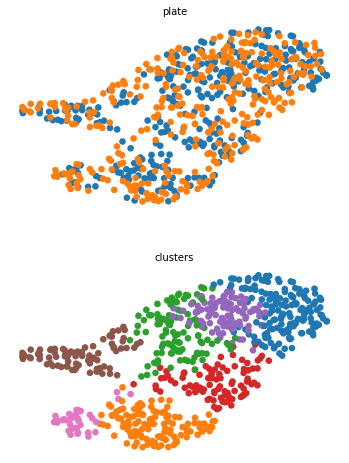

In [8]:
scv.pl.umap(adata, color=['plate', 'clusters'], ncols=1)

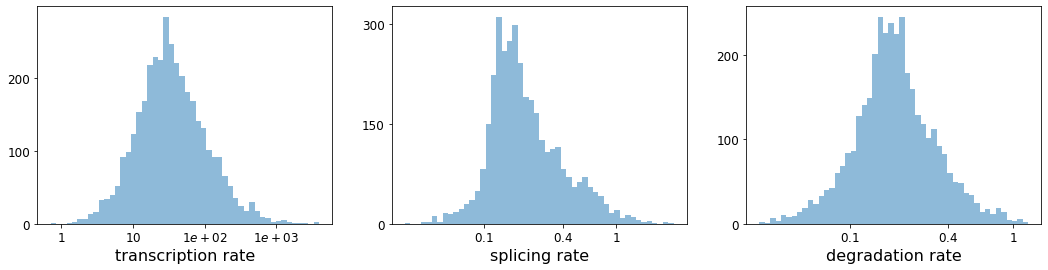

,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
Gene,,,,,,,,,,,,,,,,
Mrpl15,0.245010,89.092629,8.433143,0.197737,13.023676,0.023205,2.982156,60.721760,0.256305,0.0,0.0,0.499407,8.715617,347.667693,0.875351,2.299510
Cops5,0.029845,86.874730,6.490320,0.059127,44.836040,0.014944,2.944990,93.114578,0.239730,0.0,0.0,0.499730,9.785717,1295.726725,1.006165,4.639577
Arfgef1,0.352237,47.545827,0.508188,0.175383,16.836989,0.270990,11.923873,20.790575,0.229089,0.0,0.0,0.496747,77.401961,207.845293,1.114706,3.267649
Tram1,0.306486,65.999971,1.348508,0.165782,16.242673,0.098511,8.054241,38.631401,0.223699,0.0,0.0,0.498622,40.189846,292.259402,1.215011,3.387452
Stau2,0.013013,15.854922,0.425741,0.404437,20.658878,1.500426,8.313961,8.436275,0.232670,0.0,0.0,0.493947,36.436785,31.562216,1.009203,2.269906


In [9]:
# kinetic rate params
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)
    
test_df = scv.get_df(adata, 'fit*', dropna=True)

scv.get_df(adata, 'fit*', dropna=True).head()

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


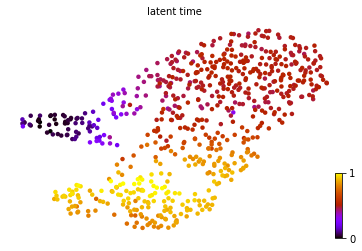

In [10]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

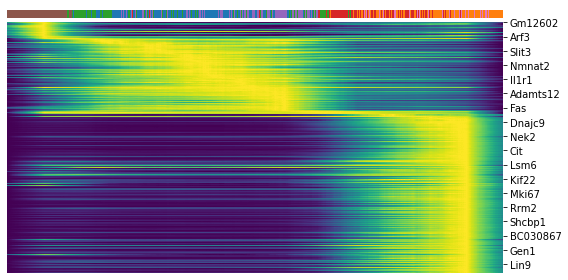

In [11]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

In [12]:
adata.var['Gene']= adata.var.index

In [13]:
adata.var.index = adata.var['Accession']

In [14]:
test_scvelo = adata.var[['fit_alpha', 'fit_beta', 'fit_gamma']]
test_scvelo['norm_fit_alpha'] = test_scvelo['fit_alpha'] / np.sum(test_scvelo['fit_alpha'])
test_scvelo['norm_fit_beta'] = test_scvelo['fit_beta'] / np.sum(test_scvelo['fit_beta'])
test_scvelo['norm_fit_gamma'] = test_scvelo['fit_gamma'] / np.sum(test_scvelo['fit_gamma'])

test_scvelo['log_2_norm_fit_alpha'] = np.log2(test_scvelo['norm_fit_alpha'])
test_scvelo['log_2_norm_fit_beta'] = np.log2(test_scvelo['norm_fit_beta'])
test_scvelo['log_2_norm_fit_gamma'] = np.log2(test_scvelo['norm_fit_gamma'])
test_scvelo.head()

,fit_alpha,fit_beta,fit_gamma,norm_fit_alpha,norm_fit_beta,norm_fit_gamma,log_2_norm_fit_alpha,log_2_norm_fit_beta,log_2_norm_fit_gamma
Accession,,,,,,,,,
ENSMUSG00000033845,89.092629,8.433143,0.197737,0.000189,0.000391,0.000201,-12.371155,-11.320582,-12.280242
ENSMUSG00000025917,86.874730,6.490320,0.059127,0.000184,0.000301,0.000060,-12.407524,-11.698363,-14.021935
ENSMUSG00000067851,47.545827,0.508188,0.175383,0.000101,0.000024,0.000178,-13.277142,-15.373218,-12.453315
ENSMUSG00000025935,65.999971,1.348508,0.165782,0.000140,0.000063,0.000169,-12.803995,-13.965288,-12.534542
ENSMUSG00000025937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
cast_genes_with_params = pd.read_csv("data_arme/F1_ref/umiSplit_cast.qc.maxl.ci.wfilt1.csv", index_col=0, header=None)
test_cast_sandberg = cast_genes_with_params[[1,2,3]]

In [16]:
test_cast_sandberg.columns = ['cast_alpha', 'cast_beta', 'cast_gamma']

In [17]:
test_cast_sandberg=test_cast_sandberg[test_cast_sandberg.index.isin(test_scvelo.index)]

In [18]:
test_cast_sandberg['norm_cast_alpha'] = test_cast_sandberg['cast_alpha'] / np.sum(test_cast_sandberg['cast_alpha'])
test_cast_sandberg['norm_cast_beta'] = test_cast_sandberg['cast_beta'] / np.sum(test_cast_sandberg['cast_beta'])
test_cast_sandberg['norm_cast_gamma'] = test_cast_sandberg['cast_gamma'] / np.sum(test_cast_sandberg['cast_gamma'])

test_cast_sandberg['log_2_norm_cast_alpha'] = np.log2(test_cast_sandberg['norm_cast_alpha'])
test_cast_sandberg['log_2_norm_cast_beta'] = np.log2(test_cast_sandberg['norm_cast_beta'])
test_cast_sandberg['log_2_norm_cast_gamma'] = np.log2(test_cast_sandberg['norm_cast_gamma'])

test_cast_sandberg = test_cast_sandberg.reindex(test_scvelo.index)
test_cast_sandberg.head()

,cast_alpha,cast_beta,cast_gamma,norm_cast_alpha,norm_cast_beta,norm_cast_gamma,log_2_norm_cast_alpha,log_2_norm_cast_beta,log_2_norm_cast_gamma
Accession,,,,,,,,,
ENSMUSG00000033845,2.592323,13.200371,54.760191,0.000271,0.000037,0.000035,-11.848626,-14.724749,-14.783492
ENSMUSG00000025917,2.570270,5.480780,53.750561,0.000269,0.000015,0.000035,-11.860952,-15.992875,-14.810340
ENSMUSG00000067851,1.048062,1.762602,11.939381,0.000110,0.000005,0.000008,-13.155148,-17.629549,-16.980892
ENSMUSG00000025935,3.991156,109.553605,104.268557,0.000417,0.000307,0.000068,-11.226065,-11.671763,-13.854387
ENSMUSG00000025937,1.553797,3.679968,12.794628,0.000163,0.000010,0.000008,-12.587074,-16.567563,-16.881081


In [19]:
c57_genes_with_params = pd.read_csv("data_arme/F1_ref/umiSplit_c57.qc.maxl.ci.wfilt1.csv", index_col=0, header=None)
test_c57_sandberg = c57_genes_with_params[[1,2,3]]

In [20]:
test_c57_sandberg.columns = ['c57_alpha', 'c57_beta', 'c57_gamma']

In [21]:
test_c57_sandberg=test_c57_sandberg[test_c57_sandberg.index.isin(test_scvelo.index)]

In [22]:
test_c57_sandberg['norm_c57_alpha'] = test_c57_sandberg['c57_alpha'] / np.sum(test_c57_sandberg['c57_alpha'])
test_c57_sandberg['norm_c57_beta'] = test_c57_sandberg['c57_beta'] / np.sum(test_c57_sandberg['c57_beta'])
test_c57_sandberg['norm_c57_gamma'] = test_c57_sandberg['c57_gamma'] / np.sum(test_c57_sandberg['c57_gamma'])

test_c57_sandberg['log_2_norm_c57_alpha'] = np.log2(test_c57_sandberg['norm_c57_alpha'])
test_c57_sandberg['log_2_norm_c57_beta'] = np.log2(test_c57_sandberg['norm_c57_beta'])
test_c57_sandberg['log_2_norm_c57_gamma'] = np.log2(test_c57_sandberg['norm_c57_gamma'])

test_c57_sandberg = test_c57_sandberg.reindex(test_scvelo.index)
test_c57_sandberg.head()

,c57_alpha,c57_beta,c57_gamma,norm_c57_alpha,norm_c57_beta,norm_c57_gamma,log_2_norm_c57_alpha,log_2_norm_c57_beta,log_2_norm_c57_gamma
Accession,,,,,,,,,
ENSMUSG00000033845,3.566200,370.535234,1019.505666,0.000372,0.001116,0.000709,-11.391101,-9.807484,-10.461442
ENSMUSG00000025917,2.776727,7.619097,66.171653,0.000290,0.000023,0.000046,-11.752104,-15.411331,-14.406955
ENSMUSG00000067851,0.747915,1.044043,10.068307,0.000078,0.000003,0.000007,-13.644543,-18.278770,-17.123347
ENSMUSG00000025935,2.145497,5.523460,11.649632,0.000224,0.000017,0.000008,-12.124177,-15.875379,-16.912884
ENSMUSG00000025937,2.057904,9.105173,20.152491,0.000215,0.000027,0.000014,-12.184313,-15.154265,-16.122210


In [23]:
test_merged = test_scvelo.merge(test_cast_sandberg, left_index=True, right_index=True)

In [24]:
test_merged = test_merged.merge(test_c57_sandberg, left_index=True, right_index=True)

In [25]:
test_merged

,fit_alpha,fit_beta,fit_gamma,norm_fit_alpha,norm_fit_beta,norm_fit_gamma,log_2_norm_fit_alpha,log_2_norm_fit_beta,log_2_norm_fit_gamma,cast_alpha,...,log_2_norm_cast_gamma,c57_alpha,c57_beta,c57_gamma,norm_c57_alpha,norm_c57_beta,norm_c57_gamma,log_2_norm_c57_alpha,log_2_norm_c57_beta,log_2_norm_c57_gamma
Accession,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,89.092629,8.433143,0.197737,0.000189,3.909897e-04,0.000201,-12.371155,-11.320582,-12.280242,2.592323,...,-14.783492,3.566200,370.535234,1019.505666,0.000372,0.001116,0.000709,-11.391101,-9.807484,-10.461442
ENSMUSG00000025917,86.874730,6.490320,0.059127,0.000184,3.009137e-04,0.000060,-12.407524,-11.698363,-14.021935,2.570270,...,-14.810340,2.776727,7.619097,66.171653,0.000290,0.000023,0.000046,-11.752104,-15.411331,-14.406955
ENSMUSG00000067851,47.545827,0.508188,0.175383,0.000101,2.356136e-05,0.000178,-13.277142,-15.373218,-12.453315,1.048062,...,-16.980892,0.747915,1.044043,10.068307,0.000078,0.000003,0.000007,-13.644543,-18.278770,-17.123347
ENSMUSG00000025935,65.999971,1.348508,0.165782,0.000140,6.252148e-05,0.000169,-12.803995,-13.965288,-12.534542,3.991156,...,-13.854387,2.145497,5.523460,11.649632,0.000224,0.000017,0.000008,-12.124177,-15.875379,-16.912884
ENSMUSG00000025937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.553797,...,-16.881081,2.057904,9.105173,20.152491,0.000215,0.000027,0.000014,-12.184313,-15.154265,-16.122210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000036768,47.727543,0.642637,0.481324,0.000101,2.979487e-05,0.000489,-13.271639,-15.034577,-10.996816,0.074438,...,-18.293328,0.109660,0.961881,6.828209,0.000011,0.000003,0.000005,-16.414386,-18.397021,-17.683589
ENSMUSG00000025785,237.532262,12.889256,0.536921,0.000503,5.975906e-04,0.000546,-10.956409,-10.708555,-10.839116,1.799045,...,-14.541364,1.329761,8.392497,39.008256,0.000139,0.000025,0.000027,-12.814322,-15.271851,-15.169388
ENSMUSG00000035202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104777,...,-17.437217,0.391855,0.459469,10.490317,0.000041,0.000001,0.000007,-14.577096,-19.462911,-17.064110


In [26]:
test_merged['Gene'] = adata.var['Gene']

In [27]:
test_merged['id']= test_merged.index

<AxesSubplot:xlabel='Accession'>

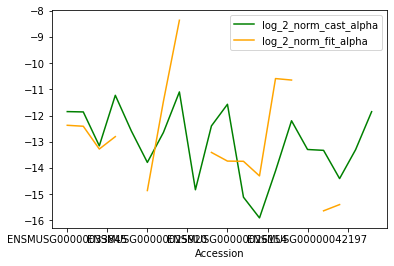

In [28]:
test_merged[:20][['log_2_norm_cast_alpha', 'log_2_norm_fit_alpha']].plot(color=['green', 'orange'])

<AxesSubplot:xlabel='Accession'>

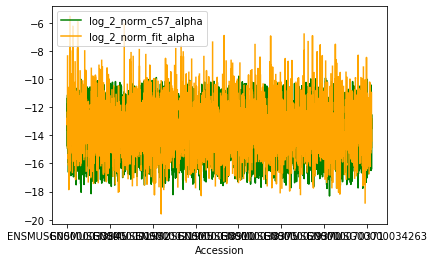

In [29]:
test_merged[['log_2_norm_c57_alpha', 'log_2_norm_fit_alpha']].plot(color=['green', 'orange'])

<AxesSubplot:xlabel='Accession'>

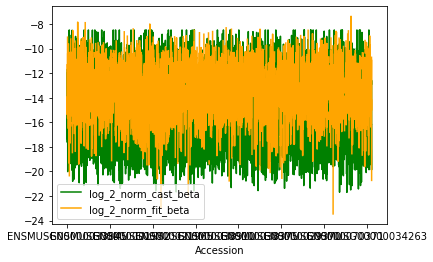

In [30]:
test_merged[['log_2_norm_cast_beta', 'log_2_norm_fit_beta']].plot(color=['green', 'orange'])

<AxesSubplot:xlabel='Accession'>

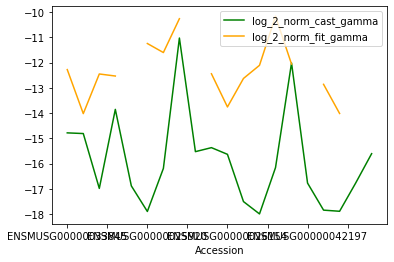

In [31]:
test_merged[['log_2_norm_cast_gamma', 'log_2_norm_fit_gamma']][:20].plot(color=['green', 'orange'])

<AxesSubplot:xlabel='log_2_norm_cast_alpha', ylabel='Density'>

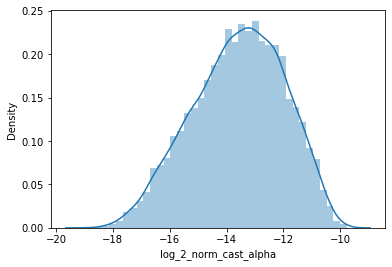

In [32]:
sns.distplot(test_merged['log_2_norm_cast_alpha'])

<AxesSubplot:xlabel='log_2_norm_c57_alpha', ylabel='Density'>

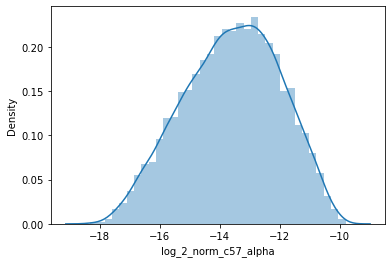

In [33]:
sns.distplot(test_merged['log_2_norm_c57_alpha'])

<AxesSubplot:xlabel='log_2_norm_fit_alpha', ylabel='Density'>

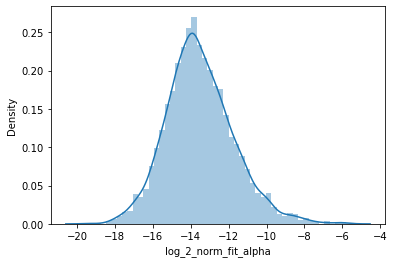

In [34]:
sns.distplot(test_merged['log_2_norm_fit_alpha'])

<AxesSubplot:xlabel='id'>

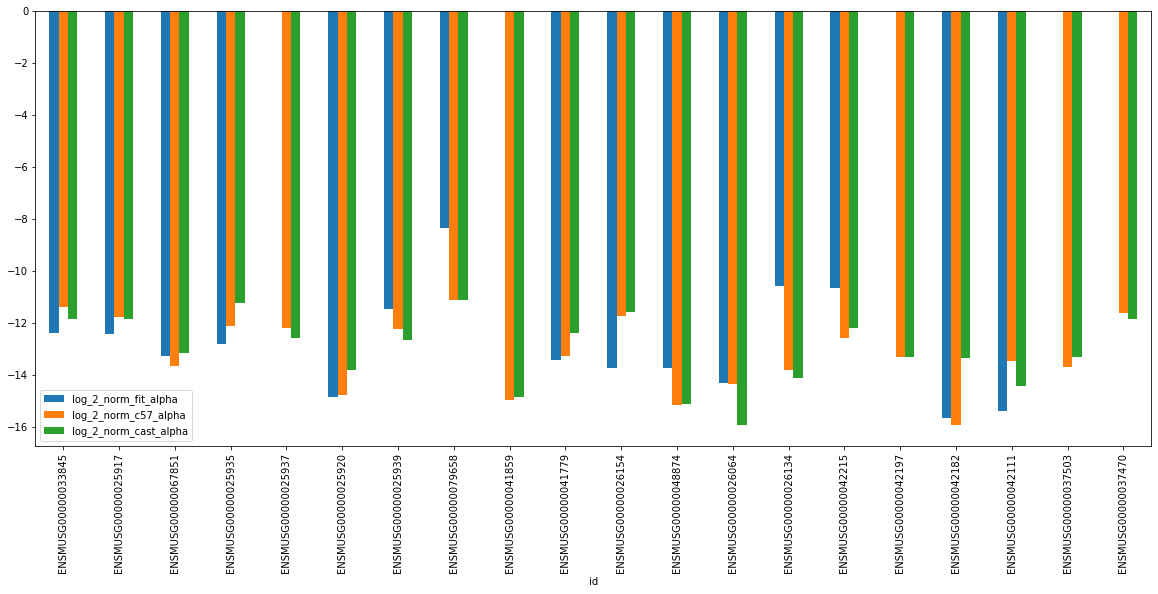

In [35]:
test_merged[:20].plot(x="id", y=["log_2_norm_fit_alpha", "log_2_norm_c57_alpha", "log_2_norm_cast_alpha"], kind="bar", figsize=(20, 8))

In [36]:
test_merged.head(20)

,fit_alpha,fit_beta,fit_gamma,norm_fit_alpha,norm_fit_beta,norm_fit_gamma,log_2_norm_fit_alpha,log_2_norm_fit_beta,log_2_norm_fit_gamma,cast_alpha,...,c57_beta,c57_gamma,norm_c57_alpha,norm_c57_beta,norm_c57_gamma,log_2_norm_c57_alpha,log_2_norm_c57_beta,log_2_norm_c57_gamma,Gene,id
Accession,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,89.092629,8.433143,0.197737,0.000189,0.000391,0.000201,-12.371155,-11.320582,-12.280242,2.592323,...,370.535234,1019.505666,0.000372,0.001116,0.000709,-11.391101,-9.807484,-10.461442,Mrpl15,ENSMUSG00000033845
ENSMUSG00000025917,86.874730,6.490320,0.059127,0.000184,0.000301,0.000060,-12.407524,-11.698363,-14.021935,2.570270,...,7.619097,66.171653,0.000290,0.000023,0.000046,-11.752104,-15.411331,-14.406955,Cops5,ENSMUSG00000025917
ENSMUSG00000067851,47.545827,0.508188,0.175383,0.000101,0.000024,0.000178,-13.277142,-15.373218,-12.453315,1.048062,...,1.044043,10.068307,0.000078,0.000003,0.000007,-13.644543,-18.278770,-17.123347,Arfgef1,ENSMUSG00000067851
ENSMUSG00000025935,65.999971,1.348508,0.165782,0.000140,0.000063,0.000169,-12.803995,-13.965288,-12.534542,3.991156,...,5.523460,11.649632,0.000224,0.000017,0.000008,-12.124177,-15.875379,-16.912884,Tram1,ENSMUSG00000025935
ENSMUSG00000025937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.553797,...,9.105173,20.152491,0.000215,0.000027,0.000014,-12.184313,-15.154265,-16.122210,Lactb2,ENSMUSG00000025937
ENSMUSG00000025920,15.854922,0.425741,0.404437,0.000034,0.000020,0.000411,-14.861530,-15.628604,-11.247912,0.676144,...,0.673229,3.422720,0.000035,0.000002,0.000002,-14.782814,-18.911781,-18.679953,Stau2,ENSMUSG00000025920
ENSMUSG00000025939,166.805152,1.501007,0.315647,0.000353,0.000070,0.000321,-11.466369,-13.810722,-11.605513,1.488950,...,15.118557,56.766149,0.000206,0.000046,0.000039,-12.244177,-14.422702,-14.628137,Ube2w,ENSMUSG00000025939
ENSMUSG00000079658,1435.242520,40.177166,0.798577,0.003041,0.001863,0.000812,-8.361310,-9.068348,-10.266393,4.364173,...,189.501795,1936.892209,0.000446,0.000571,0.001347,-11.129444,-10.774883,-9.535568,Tceb1,ENSMUSG00000079658
ENSMUSG00000041859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.327866,...,2.516696,41.851713,0.000031,0.000008,0.000029,-14.962434,-17.009420,-15.067881,Mcm3,ENSMUSG00000041859


In [37]:
# sns.scatterplot()

In [38]:
# test_merged.to_csv('data/test_merged.csv')


adata.var['norm_fit_alpha'] = test_merged['norm_fit_alpha']
adata.var['cast_alpha'] = test_merged['cast_alpha']
adata.var['c57_alpha'] = test_merged['c57_alpha']
adata.var['norm_c57_alpha'] = test_merged['norm_c57_alpha']
adata.var['norm_cast_alpha'] = test_merged['norm_cast_alpha']


In [39]:
adata.var.index = adata.var['Gene']

In [40]:
adata.write('data/with_params.h5ad')

In [41]:
adata.var

,Accession,Chromosome,End,Start,Strand,gene_count_corr,fit_r2,fit_alpha,fit_beta,fit_gamma,...,fit_steady_s,fit_variance,fit_alignment_scaling,velocity_genes,Gene,norm_fit_alpha,cast_alpha,c57_alpha,norm_c57_alpha,norm_cast_alpha
Gene,,,,,,,,,,,,,,,,,,,,,
Mrpl15,ENSMUSG00000033845,1,4785739,4773206,-,NaN,0.245010,89.092629,8.433143,0.197737,...,347.667693,0.875351,2.299510,False,Mrpl15,0.000189,2.592323,3.566200,0.000372,0.000271
Cops5,ENSMUSG00000025917,1,10038127,10024602,-,NaN,0.029845,86.874730,6.490320,0.059127,...,1295.726725,1.006165,4.639577,False,Cops5,0.000184,2.570270,2.776727,0.000290,0.000269
Arfgef1,ENSMUSG00000067851,1,10232670,10137571,-,NaN,0.352237,47.545827,0.508188,0.175383,...,207.845293,1.114706,3.267649,True,Arfgef1,0.000101,1.048062,0.747915,0.000078,0.000110
Tram1,ENSMUSG00000025935,1,13589864,13564702,-,NaN,0.306486,65.999971,1.348508,0.165782,...,292.259402,1.215011,3.387452,True,Tram1,0.000140,3.991156,2.145497,0.000224,0.000417
Lactb2,ENSMUSG00000025937,1,13660546,13624845,-,NaN,-1.179060,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Lactb2,NaN,1.553797,2.057904,0.000215,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kif15,ENSMUSG00000036768,9,123018725,122951081,+,NaN,0.646532,47.727543,0.642637,0.481324,...,72.922605,0.182808,1.531682,True,Kif15,0.000101,0.074438,0.109660,0.000011,0.000008
Exosc7,ENSMUSG00000025785,9,123136129,123113215,+,NaN,0.180981,237.532262,12.889256,0.536921,...,438.417973,0.557635,1.764227,False,Exosc7,0.000503,1.799045,1.329761,0.000139,0.000188
Lars2,ENSMUSG00000035202,9,123462664,123366940,+,NaN,-0.422694,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Lars2,NaN,0.104777,0.391855,0.000041,0.000011


In [42]:
test_merged['norm_fit_alpha']

Accession
ENSMUSG00000033845    0.000189
ENSMUSG00000025917    0.000184
ENSMUSG00000067851    0.000101
ENSMUSG00000025935    0.000140
ENSMUSG00000025937         NaN
                        ...   
ENSMUSG00000036768    0.000101
ENSMUSG00000025785    0.000503
ENSMUSG00000035202         NaN
ENSMUSG00000025240    0.000139
ENSMUSG00000035299    0.000046
Name: norm_fit_alpha, Length: 7119, dtype: float64

In [43]:
# c57_genes_with_params

In [44]:
test_merged_wo_na = test_merged.dropna()

In [45]:
np.linalg.norm(test_merged_wo_na['norm_cast_alpha'].values - test_merged_wo_na['norm_c57_alpha'].values,axis=0)

0.0038708476938614173

In [46]:
np.linalg.norm(test_merged_wo_na['norm_fit_alpha'].values - test_merged_wo_na['norm_c57_alpha'].values,axis=0)

0.05320005107936349

In [47]:
np.linalg.norm(test_merged_wo_na['norm_fit_alpha'].values - test_merged_wo_na['norm_cast_alpha'].values,axis=0)

0.05322960535102508

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [49]:
1 - cosine(test_merged_wo_na["norm_cast_alpha"], test_merged_wo_na["norm_c57_alpha"])

0.9498578997711304

In [50]:
1 - cosine(test_merged_wo_na["norm_fit_alpha"], test_merged_wo_na["norm_c57_alpha"])

0.28525341419849237

In [51]:
1 - cosine(test_merged_wo_na["norm_fit_alpha"], test_merged_wo_na["norm_cast_alpha"])

0.28293488214257023

In [52]:
cosine_similarity(test_merged_wo_na["norm_cast_alpha"].values.reshape(1, -1), 
                  test_merged_wo_na["norm_c57_alpha"].values.reshape(1, -1))

array([[0.9498579]])

In [53]:
cosine_similarity(test_merged_wo_na["norm_fit_alpha"].values.reshape(1, -1), 
                  test_merged_wo_na["norm_c57_alpha"].values.reshape(1, -1))

array([[0.28525341]])

In [54]:
cosine_similarity(test_merged_wo_na["norm_fit_alpha"].values.reshape(1, -1), 
                  test_merged_wo_na["norm_cast_alpha"].values.reshape(1, -1))

array([[0.28293488]])

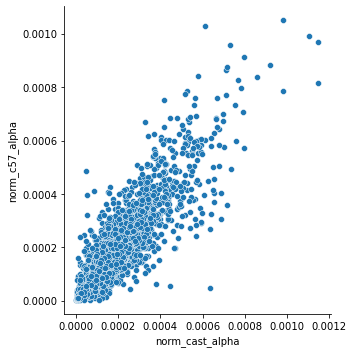

In [55]:
sns.relplot(x="norm_cast_alpha", y="norm_c57_alpha", data=test_merged_wo_na);

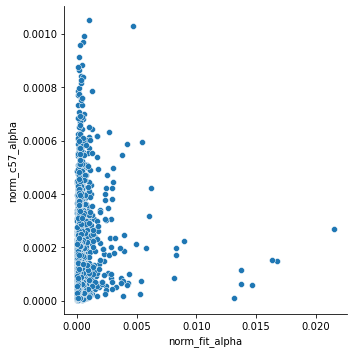

In [56]:
sns.relplot(x="norm_fit_alpha", y="norm_c57_alpha", data=test_merged_wo_na);

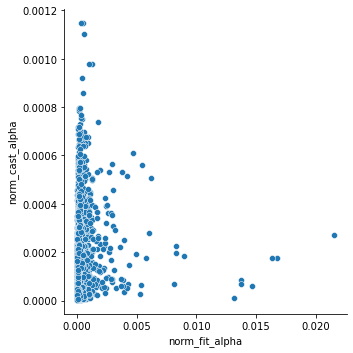

In [57]:
sns.relplot(x="norm_fit_alpha", y="norm_cast_alpha", data=test_merged_wo_na);

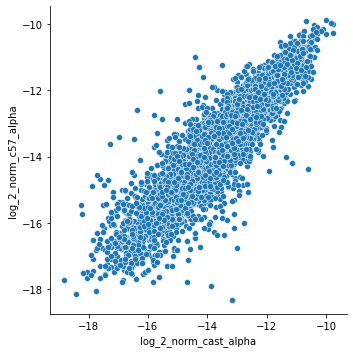

In [58]:
sns.relplot(x="log_2_norm_cast_alpha", y="log_2_norm_c57_alpha", data=test_merged_wo_na);

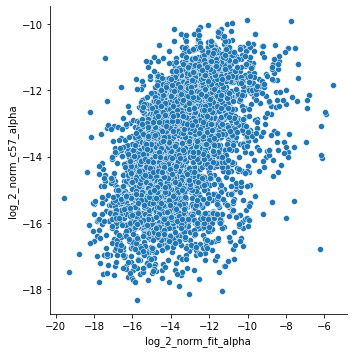

In [59]:
sns.relplot(x="log_2_norm_fit_alpha", y="log_2_norm_c57_alpha", data=test_merged_wo_na);

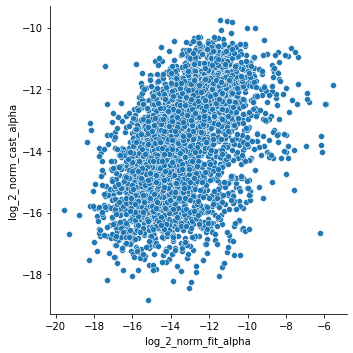

In [60]:
sns.relplot(x="log_2_norm_fit_alpha", y="log_2_norm_cast_alpha", data=test_merged_wo_na);